In [1]:
import pyarrow.parquet as pq
import pyarrow.hdfs as hdfs
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import logging
from datetime import datetime

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

try:
    hdfs_client = hdfs.connect(host='namenode', port=9000)
except Exception as e:
    print(f"Failed to connect to HDFS: {e}")
    raise

def read_parquet_from_hdfs(hdfs_client, path):
    try:
        with hdfs_client.open(f'{path}/_SUCCESS', 'rb') as f:
            pass
        dataset = pq.ParquetDataset(path, filesystem=hdfs_client)
        table = dataset.read()
        return table.to_pandas()
    except Exception as e:
        print(f"Error reading Parquet from {path}: {e}")
        raise

df_averages = read_parquet_from_hdfs(hdfs_client, 'hdfs://namenode:9000/user/hive/warehouse/crypto_averages')
df_segments = read_parquet_from_hdfs(hdfs_client, 'hdfs://namenode:9000/user/hive/warehouse/crypto_segment_aggregates')

df_averages['date'] = pd.to_datetime(df_averages['date'])
df_segments['date'] = pd.to_datetime(df_segments['date'])
df_averages = df_averages.sort_values('date')
df_segments = df_segments.sort_values('date')

duplicates_averages = df_averages.duplicated(subset=['cryptocurrency', 'date']).sum()
if duplicates_averages > 0:
    df_averages = df_averages.drop_duplicates(subset=['cryptocurrency', 'date'])

missing_values_averages = df_averages[['cryptocurrency', 'date', 'price_usd', 'price_change_percent_24h']].isna().sum()
if missing_values_averages.any():
    df_averages = df_averages.dropna(subset=['price_usd', 'price_change_percent_24h'])

duplicates_segments = df_segments.duplicated(subset=['segment', 'date']).sum()
if duplicates_segments > 0:
    df_segments = df_segments.drop_duplicates(subset=['segment', 'date'])

missing_values_segments = df_segments[['segment', 'date', 'avg_market_cap', 'avg_volume_24h']].isna().sum()
if missing_values_segments.any():
    df_segments = df_segments.dropna(subset=['avg_market_cap', 'avg_volume_24h'])

df_segments = df_segments[~((df_segments['segment'] == 'volatile') & (df_segments['date'].dt.date == pd.to_datetime('2025-04-20').date()))]

colors = sns.color_palette("husl", n_colors=5)

/tmp/ipykernel_7969/2394608748.py:14: FutureWarning: pyarrow.hdfs.connect is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  hdfs_client = hdfs.connect(host='namenode', port=9000)
/tmp/ipykernel_7969/2394608748.py:23: FutureWarning: Passing 'use_legacy_dataset=True' to get the legacy behaviour is deprecated as of pyarrow 11.0.0, and the legacy implementation will be removed in a future version. The legacy behaviour was still chosen because a deprecated 'pyarrow.filesystem' filesystem was specified (use the filesystems from pyarrow.fs instead).
  dataset = pq.ParquetDataset(path, filesystem=hdfs_client)
/tmp/ipykernel_7969/2394608748.py:23: FutureWarning: Passing 'use_legacy_dataset=True' to get the legacy behaviour is deprecated as of pyarrow 11.0.0, and the legacy implementation will be removed in a future version. The legacy behaviour was still chosen because a deprecated 'pyarrow.filesystem' filesystem was specified (use the filesystems from pyarrow.fs inst

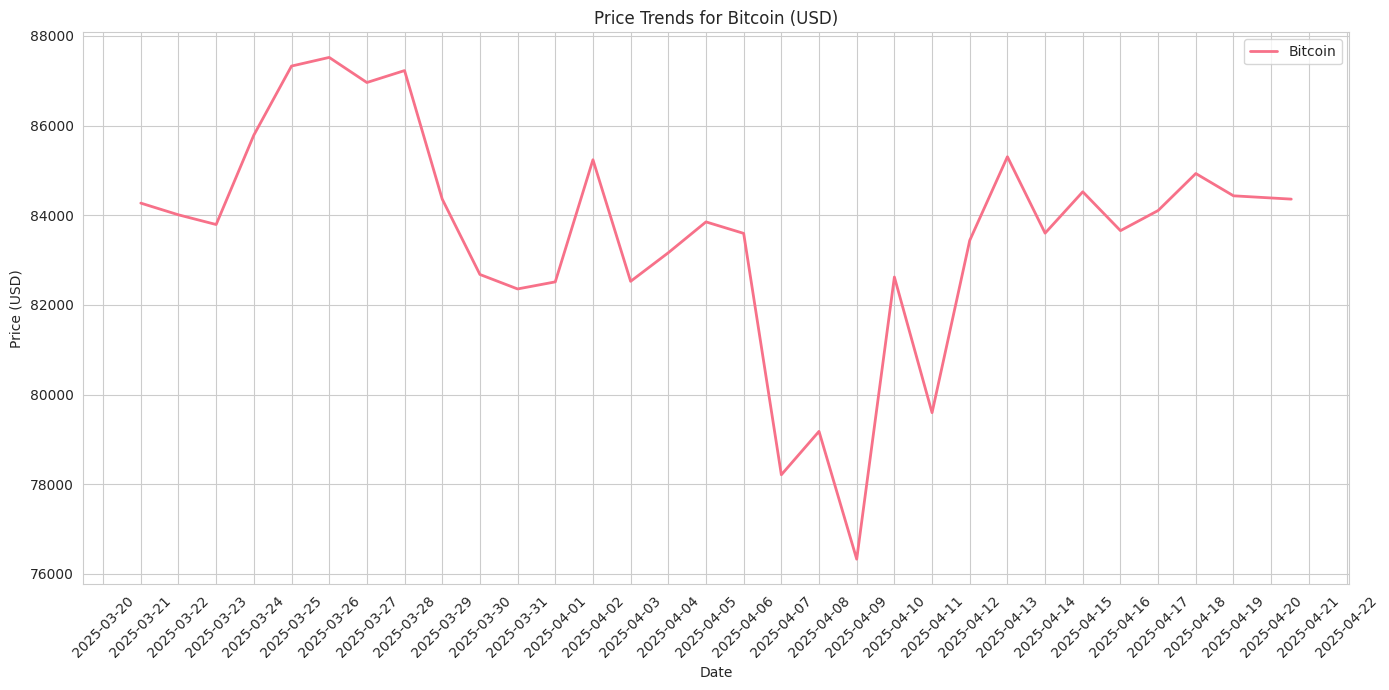

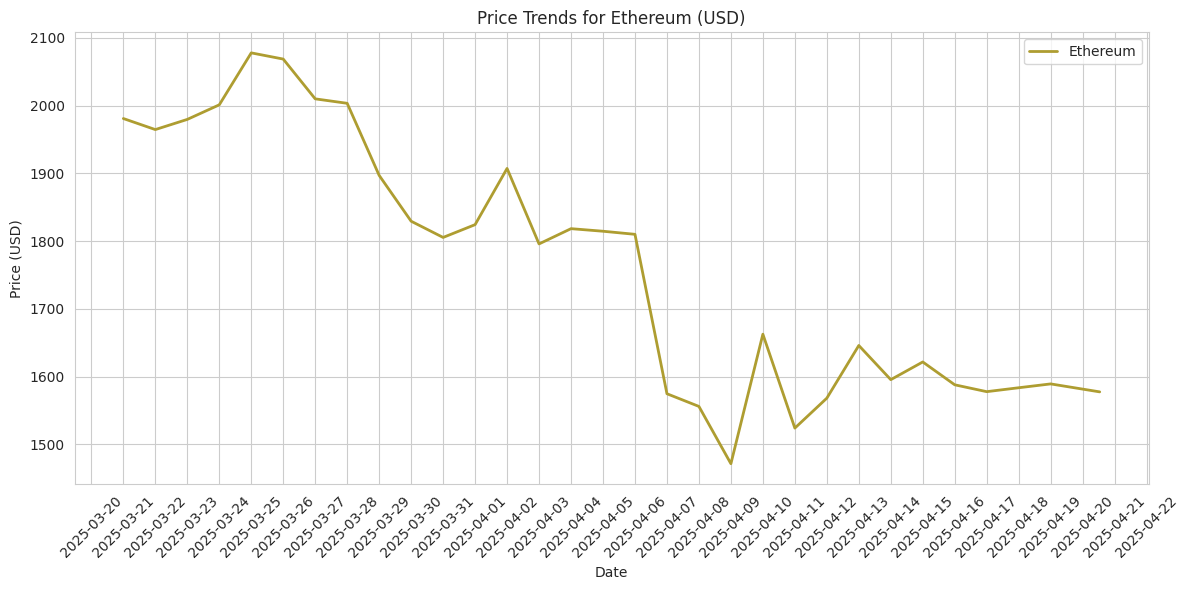

In [2]:
# 1. Временные ряды цен для Bitcoin и Ethereum
df_prices = df_averages[df_averages['cryptocurrency'].isin(['Bitcoin', 'Ethereum'])]
plt.figure(figsize=(14, 7))
for i, crypto in enumerate(['Bitcoin', 'Ethereum']):
    crypto_data = df_prices[df_prices['cryptocurrency'] == crypto]
    plt.plot(crypto_data['date'], crypto_data['price_usd'], label=crypto, color=colors[i], linewidth=2)
    plt.title(f'Price Trends for {crypto} (USD)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.tight_layout()
    plt.show()

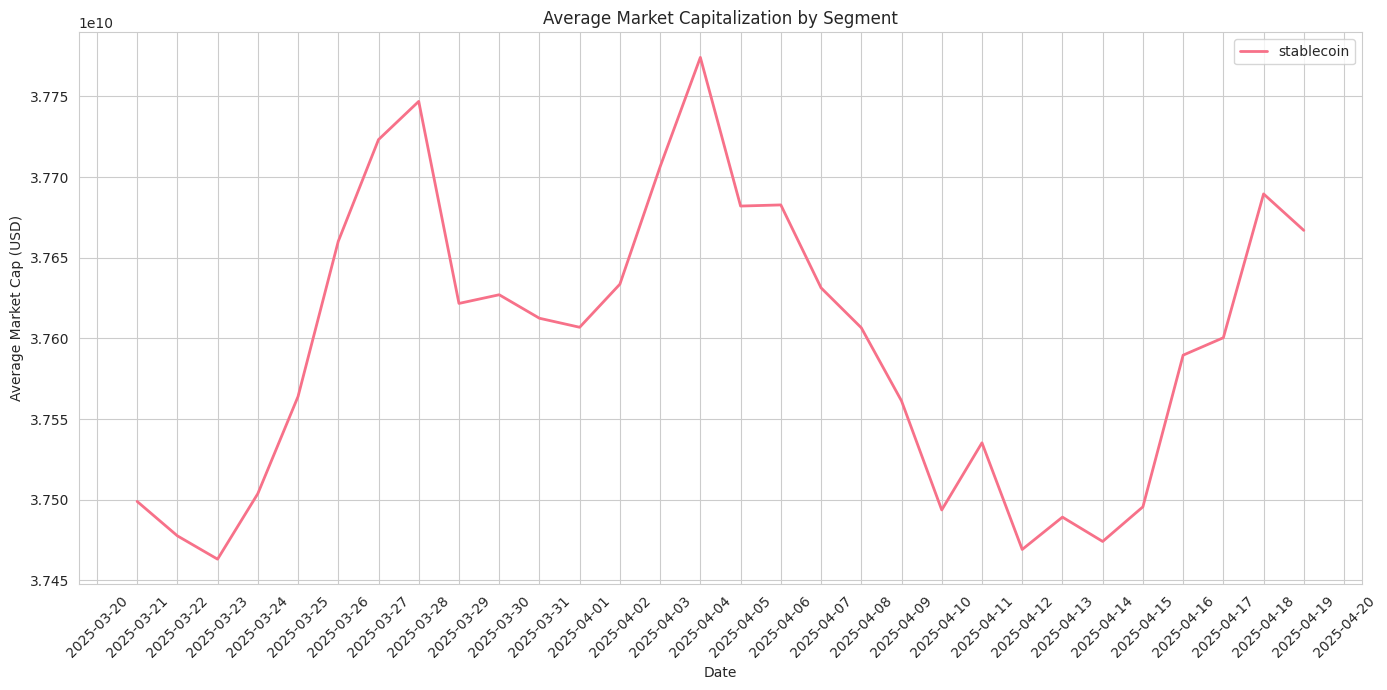

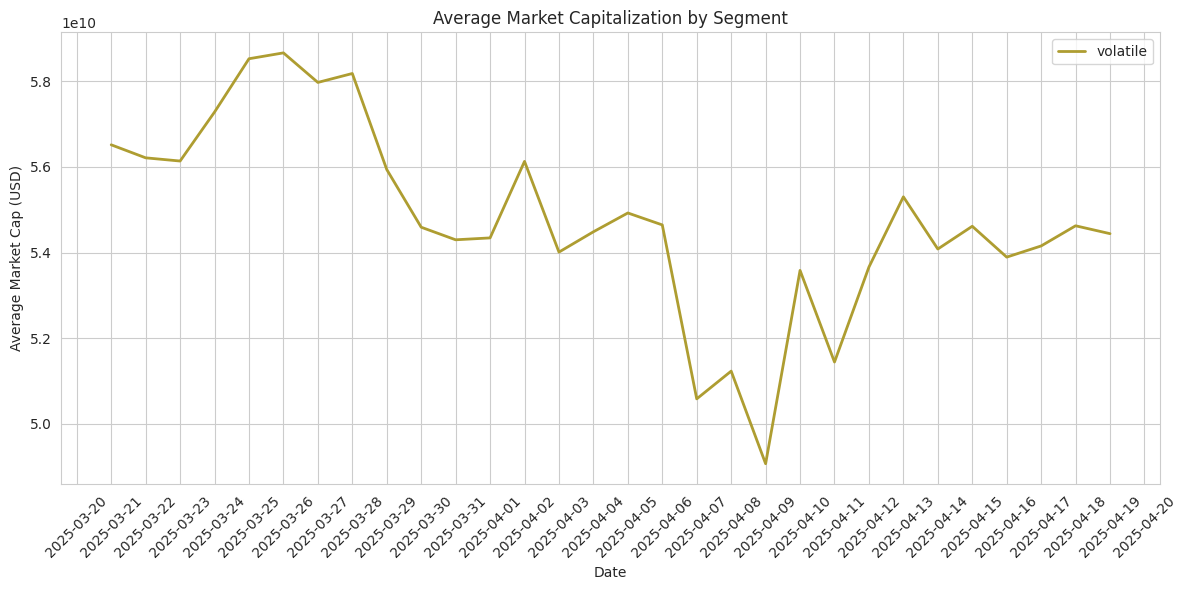

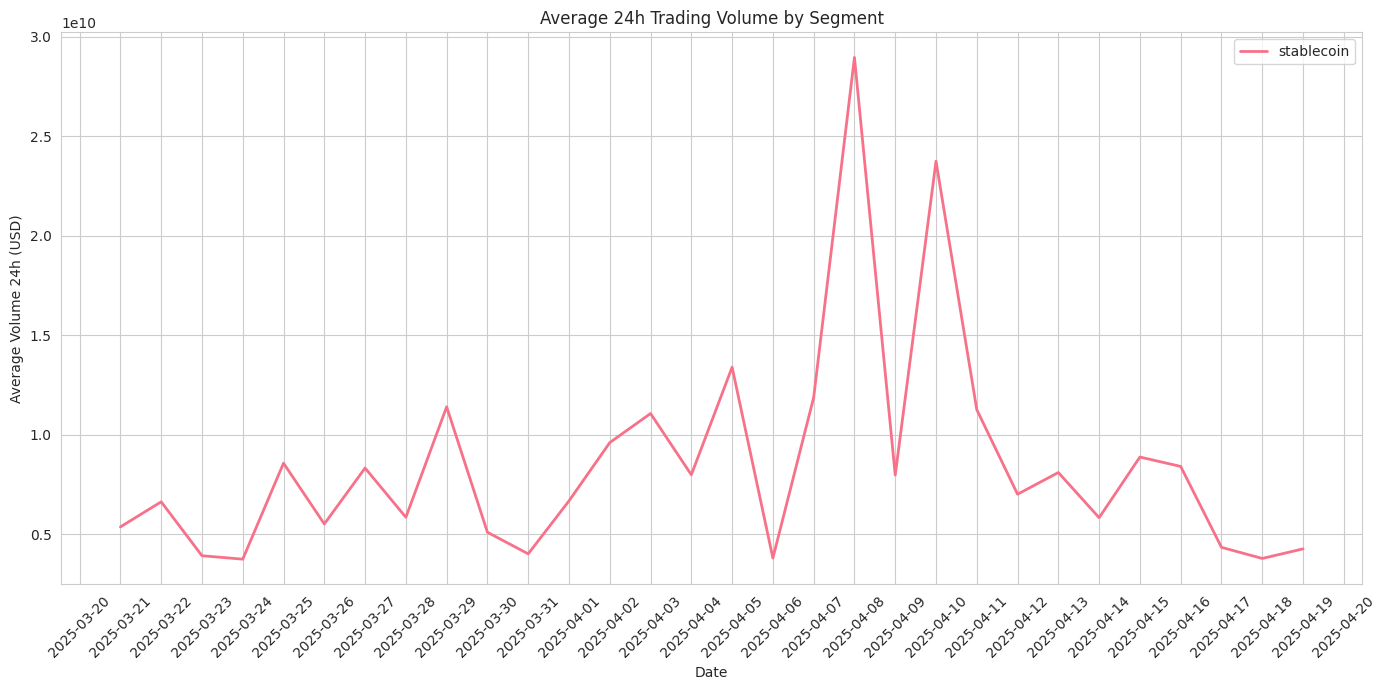

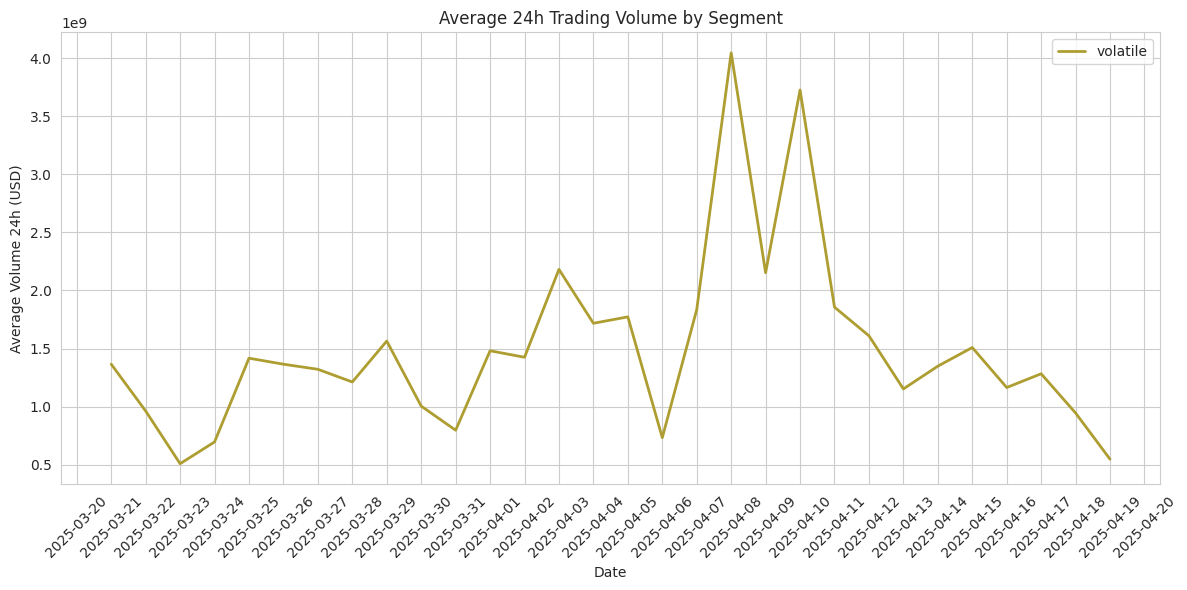

In [3]:
# 2. Сравнение рыночных сегментов (stablecoins vs volatile)
# График средней рыночной капитализации
plt.figure(figsize=(14, 7))
for i, segment in enumerate(df_segments['segment'].unique()):
    segment_data = df_segments[df_segments['segment'] == segment]
    plt.plot(segment_data['date'], segment_data['avg_market_cap'], label=segment, color=colors[i], linewidth=2)
    plt.title('Average Market Capitalization by Segment')
    plt.xlabel('Date')
    plt.ylabel('Average Market Cap (USD)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.tight_layout()
    plt.show()

# График среднего объема торгов
plt.figure(figsize=(14, 7))
for i, segment in enumerate(df_segments['segment'].unique()):
    segment_data = df_segments[df_segments['segment'] == segment]
    plt.plot(segment_data['date'], segment_data['avg_volume_24h'], label=segment, color=colors[i], linewidth=2)
    plt.title('Average 24h Trading Volume by Segment')
    plt.xlabel('Date')
    plt.ylabel('Average Volume 24h (USD)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.tight_layout()
    plt.show()

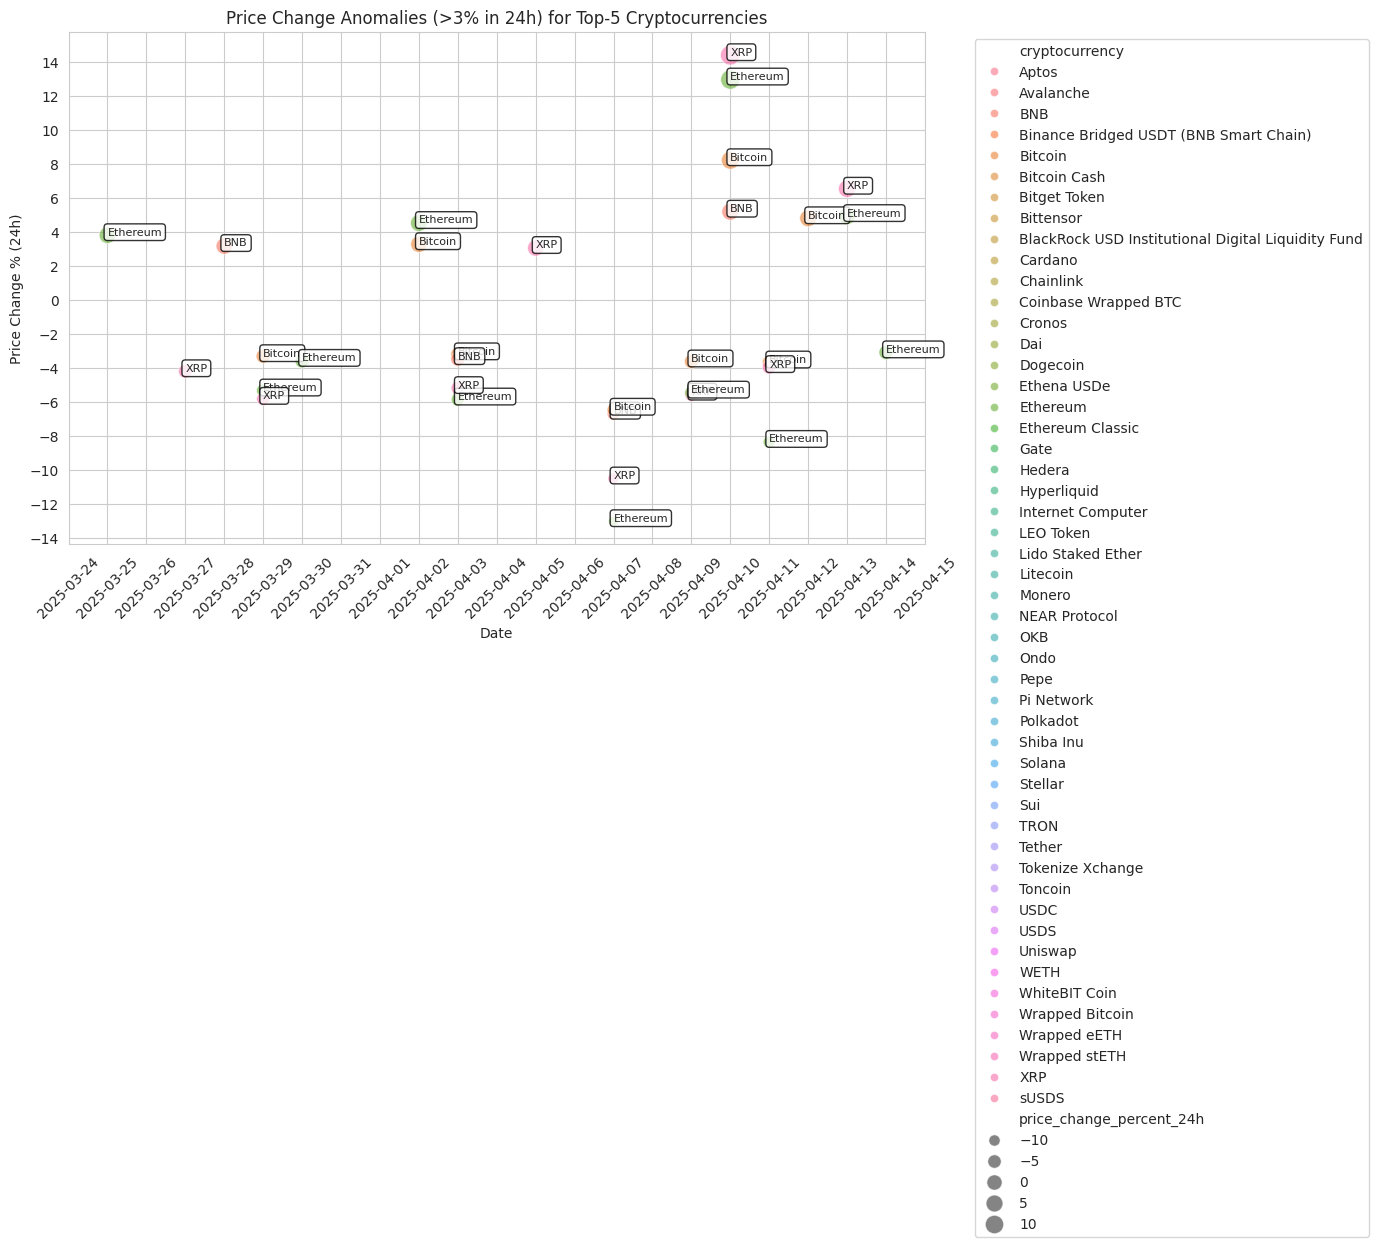

In [30]:
# 3. Анализ аномалий (ценовые изменения более 3%)
top_cryptos = df_averages.groupby('cryptocurrency')['market_cap'].mean().nlargest(5).index
df_anomalies = df_averages[
    (df_averages['price_change_percent_24h'].abs() >= 3) &
    (df_averages['cryptocurrency'].isin(top_cryptos))
]
plt.figure(figsize=(14, 10))
scatter = sns.scatterplot(
    data=df_anomalies,
    x='date',
    y='price_change_percent_24h',
    hue='cryptocurrency',
    size='price_change_percent_24h',
    sizes=(50, 200),
    palette='husl',
    alpha=0.6
)
texts = []
for i, row in df_anomalies[df_anomalies['price_change_percent_24h'].abs() >= 3].iterrows():
    text = plt.text(
        row['date'],
        row['price_change_percent_24h'],
        row['cryptocurrency'],
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8)
    )
    texts.append(text)
plt.title('Price Change Anomalies (>3% in 24h) for Top-5 Cryptocurrencies')
plt.xlabel('Date')
plt.ylabel('Price Change % (24h)')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(2))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [5]:
hdfs_client.close()